<a href="https://colab.research.google.com/github/hungrynagini/movie_tag_prediction/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [6]:
directory = "/content/drive/My Drive/Colab Notebooks/ai/"
metadata = pd.read_csv(directory+'movies_metadata.csv')
keywords = pd.read_csv(directory+'keywords.csv')
plots = pd.read_csv(directory+'movie_plots.csv')
top_keywords = 30

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
def get_stop_words(stop_file_path,comma):
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        if comma:
            stopwords = f.readlines()[0].split(',')
        else:
            stopwords = f.readlines()
        print(len(stopwords))
        stop_set = set(m.strip().lower() for m in stopwords)
        return frozenset(stop_set)

def try_load(row):
    try:
        jsonparse = json.loads(row)
        return jsonparse
    except Exception as e:
        return []

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

In [9]:
metadata[:2]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [0]:
plots = plots[['Release Year','Title','Plot']]
metadata = metadata[['original_title','title','overview','tagline','release_date','id']]
metadata = metadata.apply(lambda x: x[['title','overview','tagline','release_date','id']] if type(x['title']) != float else
                          x[['original_title','overview','tagline','release_date','id']],axis=1)
metadata = metadata.fillna('0000')
plots = plots.fillna('0000')
metadata.release_date = metadata.release_date.apply(lambda x: x[:4])
metadata.release_date = metadata.release_date.astype("int64")

In [0]:
plots = plots.rename(columns={"Title": "title", "Release Year": "release_date"})
metadata.title = metadata.title.apply(lambda x: ''.join(e for e in x if e.isalnum()).lower())
plots.title = plots.title.apply(lambda x: ''.join(e for e in x if e.isalnum()).lower())

In [12]:
metadata = metadata.merge(plots, how = 'left',on=['title', 'release_date'])
metadata.sort_values(by=['title'])
metadata = metadata.drop_duplicates(subset=["title", "release_date"])
metadata = metadata.fillna("")
metadata = metadata.replace("0000","")
metadata[:2]

,id,original_title,overview,release_date,tagline,title,Plot
0,862,,"Led by Woody, Andy's toys live happily in his ...",1995,,toystory,In a world where toys are living things who pr...
1,8844,,When siblings Judy and Peter discover an encha...,1995,Roll the dice and unleash the excitement!,jumanji,"In 1869, near Brantford, New Hampshire, two br..."


In [0]:
metadata.Plot = metadata.Plot + metadata.overview + metadata.tagline
metadata = metadata.drop(['original_title','release_date','overview','tagline'],axis=1)
metadata.sort_values(by=['title'])
metadata['length'] = metadata.Plot.apply(lambda x: len(x))
metadata = metadata[metadata['length'] > 50]

In [0]:
metadata.id = metadata.id.astype("int64")
metadata = metadata.merge(keywords,on=['id'])

In [15]:
metadata[:2]

,id,title,Plot,length,keywords
0,862,toystory,In a world where toys are living things who pr...,3868,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,jumanji,"In 1869, near Brantford, New Hampshire, two br...",4374,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."


In [16]:
keyw = metadata.apply(lambda x: ";".join([i['name']
                          for i in try_load(x.keywords.replace("'","\""))]) if 
                                                         len(x) > 2 and type(x) != float else 0,axis=1)
metadata = metadata.assign(kwords=keyw.values)
metadata = metadata[metadata.kwords != '']
metadata.to_csv("merged_data.csv")

,id,title,Plot,length,keywords,kwords
19,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,"[{'id': 380, 'name': 'brother brother relation...",brother brother relationship;subway;new york c...
58,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112,"[{'id': 1990, 'name': 'cupboard'}, {'id': 6186...",cupboard;games;puppet;parallel world;toy comes...


In [43]:
metadata = pd.read_csv("merged_data.csv")
metadata = metadata[metadata['length'] > 5200]
metadata

,Unnamed: 0,id,title,Plot,length,keywords,kwords
3,4,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",baby;midlife crisis;confidence;aging;daughter;...
8,10,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,"[{'id': 833, 'name': 'white house'}, {'id': 84...",white house;usa president;new love;widower;wil...
16,19,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,"[{'id': 380, 'name': 'brother brother relation...",brother brother relationship;subway;new york c...
51,58,11359,theindianinthecupboard,"On his ninth birthday, Omri receives an old cu...",8112,"[{'id': 1990, 'name': 'cupboard'}, {'id': 6186...",cupboard;games;puppet;parallel world;toy comes...
79,90,12158,vampireinbrooklyn,An abandoned ship crashes into a dockyard in B...,6581,"[{'id': 3133, 'name': 'vampire'}, {'id': 3630,...",vampire;half vampire
...,...,...,...,...,...,...,...
30087,43972,24230,nemesis,"In the near future, illegal androids have beco...",5252,"[{'id': 679, 'name': 'cyborg'}]",cyborg
30148,44126,302104,thatthingcalledtadhana,The film starts at an airport in Rome where Ma...,6086,"[{'id': 6895, 'name': 'philippines'}, {'id': 4...",philippines;destiny;pinoy
30195,44199,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952,"[{'id': 6483, 'name': 'ice hockey'}]",ice hockey
30536,44838,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624,"[{'id': 716, 'name': 'vatican'}, {'id': 717, '...",vatican;pope;priest;alternative comedy


In [44]:
vector = CountVectorizer(tokenizer=lambda x: x.split(";"))
tags = vector.fit_transform(metadata['kwords'])
print(tags.shape[1])
tag = vector.get_feature_names()
print(tag[:5])
n = tags.sum(axis=0).A1
result = dict(zip(tag,n))
# print(result)
res = pd.DataFrame(list(result.items()),columns=['tag','count'])
res = res.sort_values(['count'],ascending=False)
tag_c = res['count'].values
real_tags = res.values[:500]
metadata = metadata.drop(['keywords'],axis=1)
# for i in real_tags:
#   metadata[i[0]] = metadata.kwords.apply(lambda x: 1 if i[0] in x else 0) 
print(real_tags[:5])

4325
['17th century', '18th century', '1910s', '1930s', '1940s']
[['murder' 65]
 ['independent film' 56]
 ['duringcreditsstinger' 54]
 ['woman director' 53]
 ['based on novel' 51]]


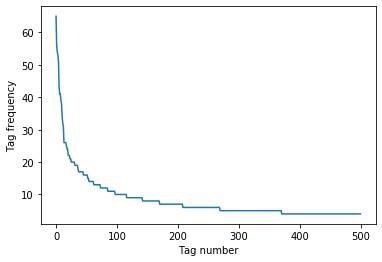

In [45]:
plt.plot(tag_c[:500])
plt.xlabel("Tag number")
plt.ylabel("Tag frequency")
plt.show()

2752     81
1574     31
4163     30
19353    29
6111     29
         ..
6416      1
6505      1
26877     1
6674      1
14106     1
Name: tag_count, Length: 1372, dtype: int64


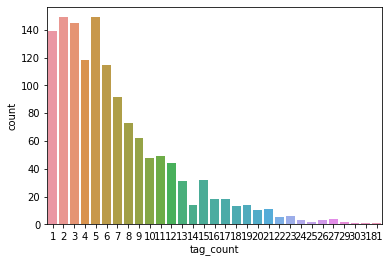

In [46]:
import seaborn as sns
metadata['tag_count'] = metadata.kwords.apply(lambda x: len(x.split(';')))
print(metadata.tag_count.sort_values(ascending=False))
sns.countplot(x=metadata['tag_count'],data=metadata)

In [47]:
test = metadata[metadata['length'] > 7700]
metadata = metadata[metadata['length'] < 7700]
metadata

,Unnamed: 0,id,title,Plot,length,kwords,tag_count
3,4,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,baby;midlife crisis;confidence;aging;daughter;...,9
8,10,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,white house;usa president;new love;widower;wil...,5
16,19,11517,moneytrain,"On Christmas, we meet foster brothers John and...",6768,brother brother relationship;subway;new york c...,5
79,90,12158,vampireinbrooklyn,An abandoned ship crashes into a dockyard in B...,6581,vampire;half vampire,2
128,152,8839,casper,"In the town of Friendship, Maine, two young bo...",5620,halloween;friendship;supernatural;afterlife;fr...,12
...,...,...,...,...,...,...,...
30087,43972,24230,nemesis,"In the near future, illegal androids have beco...",5252,cyborg,1
30148,44126,302104,thatthingcalledtadhana,The film starts at an airport in Rome where Ma...,6086,philippines;destiny;pinoy,3
30195,44199,336890,goonlastoftheenforcers,"During a pro hockey lockout, Doug ""The Thug"" G...",5952,ice hockey,1
30536,44838,79927,thepopemustdie,The plot is predicated on the Vatican being co...,5624,vatican;pope;priest;alternative comedy,4


In [0]:
movies = metadata.title.values
plots_ = metadata.Plot.values
docs = metadata.Plot
ids = metadata.id.values
kwords = metadata.kwords.values

movies_t = test.title.values
plots_t = test.Plot.values
docs_t = test.Plot
ids_t = test.id.values
kwords_t = test.kwords.values

In [49]:
#load a set of stop words
names=get_stop_words(directory+"stop.txt",True)
surnames=get_stop_words(directory+"us.txt",False)
my_stop_words = text.ENGLISH_STOP_WORDS.union(names)
my_stop_words = text.ENGLISH_STOP_WORDS.union(surnames)

5631
88799


In [50]:
metadata[:2]

,Unnamed: 0,id,title,Plot,length,kwords,tag_count
3,4,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,baby;midlife crisis;confidence;aging;daughter;...,9
8,10,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,white house;usa president;new love;widower;wil...,5


In [0]:
real_tags[0] = [real_tags[0][0], real_tags[0][1]]
for tag in range(len(real_tags)):
  if type(real_tags[tag][0]) != str:
    real_tags[tag] = real_tags[tag][0]
  # print(tag[0], type(tag[0]))

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer 
# settings for count vectorizer
# tfidf_vectorizer=TfidfVectorizer(use_idf=True,stop_words=my_stop_words,ngram_range=(1,2))
tfidf_vectorizer=TfidfVectorizer(use_idf=True,stop_words=my_stop_words,min_df=20,ngram_range=(1,2))
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)
feature_names = tfidf_vectorizer.get_feature_names()

print(feature_names[:5])
n_ = tfidf_vectorizer_vectors.sum(axis=0).A1
result_ = dict(zip(feature_names,n_))
words_probabil = pd.DataFrame(list(result_.items()),columns=['word','count'])
print(words_probabil.sort_values(by=['count'])[:10])


['000', '10', '100', '11', '12']
            word     count
1000   examining  1.338298
783   difficulty  1.343298
895      earning  1.355485
538   completing  1.358949
1290         hid  1.367794
999     examines  1.371287
1554        load  1.371595
1611  mastermind  1.375856
502       coldly  1.376458
2129  remembered  1.382883


In [53]:
metadata[:2]

,Unnamed: 0,id,title,Plot,length,kwords,tag_count
3,4,11862,fatherofthebridepartii,The film begins five years after the events of...,5474,baby;midlife crisis;confidence;aging;daughter;...,9
8,10,9087,theamericanpresident,Popular Democratic President Andrew Shepherd i...,5621,white house;usa president;new love;widower;wil...,5


In [0]:
# # potential_kwords = []
# # kwords_prob = {}
# top_keywords = 30
# # probability = pd.DataFrame(columns=['tag','keyword','probability','pair'])
# probability = {}
# leng = tfidf_vectorizer_vectors.shape[0]
# for i in range(leng):
# #   vec = tfidf_vectorizer_vectors[i]
#   first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[i]
# # place tf-idf values in a pandas data frame
#   df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=feature_names, columns=["tfidf"])
#   # df = pd.DataFrame([[vec.T.todense(), feature_names]], columns=["tfidf","tag"])
#   # df = pd.DataFrame([[vec.T.todense(), tfidf_vectorizer.get_feature_names()]], columns=["tfidf","tag"])
#   # print(df.sort_values(by=["tfidf"],ascending=False)[:20])
#   vals = df.sort_values(by=["tfidf"],ascending=False).index
#   leng_ = len(vals)
#   if leng_ <= top_keywords:
#     top_keywords = leng_
#   vals = vals[:top_keywords]
#   # for val in vals:
#   for tag in kwords[i].split(","):
#     if tag in vals:
#       # vals_without = 
#       for val in vals:
#         # if val in kwords_prob:
#         #   kwords_prob[val] += 1
#         # else:
#         #   kwords_prob[val] = 1
#         # if (probability['pair'] == tag+":"+val).any():
#         if tag+":"+val in probability:
#           # probability[probability['pair'] == tag[0]+":"+val]['probability'] += 1
#           probability[tag+":"+val] += 1
#         else:
#           # probability = probability.append({'tag': tag, 'keyword': val, 'probability': 1,'probabil_word': 1, 'pair':tag+":"+val}, ignore_index=True)
#           probability[tag+":"+val] = 1

#   metadata.loc[metadata['id'] == ids[i],'potential_kwords'] = ','.join(vals)

In [0]:
top_keywords = 40
c = 0
probability = pd.DataFrame(columns=['tag','keyword','probability'])
leng = tfidf_vectorizer_vectors.shape[0]
for i in range(leng):
  first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[i]
# place tf-idf values in a pandas data frame
  df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=feature_names, columns=["tfidf"])
  vals = df.sort_values(by=["tfidf"],ascending=False).index
  leng_ = len(vals)
  if leng_ <= top_keywords:
    top_keywords = leng_
  vals = vals[:top_keywords]
  for tag in kwords[i].split(";"):
    # if tag in vals: 
    for val in vals:
      c += 1
      if ((probability['tag'] == tag) & (probability['keyword'] == val)).any():
        probability.loc[(probability['tag'] == tag) & (probability['keyword'] == val),'probability'] += 1
      else:
        probability = probability.append({'tag': tag, 'keyword': val, 'probability': 1}, ignore_index=True)
  metadata.loc[metadata['id'] == ids[i],'potential_kwords'] = ','.join(vals)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
probability[:2]

In [0]:
probability = probability.loc[probability['keyword'] != probability['tag']]
probability[:2]

In [0]:
tfidf_vectors=tfidf_vectorizer.fit_transform(docs_t)
feature_names_t = tfidf_vectorizer.get_feature_names()


In [0]:
from time import perf_counter 
from sklearn.metrics import pairwise
popping = 0
inner = 0
outer = 0
start_all = perf_counter()
tags = 0
cooc_tags_list = []
nns_tags_list= []
# one_tag = 0
# print(test_indexes)
test_indexes = [i for i in range(test.shape[0])]
tags_in_table = list(set(probability.tag.values))
for j in test_indexes:
  probability_copy = probability.copy()
  print("\n",movies_t[j])
  print(plots_t[j][:100])
  print(kwords_t[j])
  first_vector=tfidf_vectors[j]
  # start_outer = perf_counter()
  sorted_items=sort_coo(first_vector.tocoo())
  keywords=extract_topn_from_vector(feature_names_t,sorted_items,20)
  # end_outer = perf_counter()
  # outer += end_outer - start_outer
  # print("out", end_outer - start_outer)
  potential = {}
  for tag in tags_in_table:
    # start_pop = perf_counter()
    tag_rows = probability_copy[probability_copy['tag'] == tag]
    probability_copy = probability_copy[probability_copy['tag'] != tag]
    # end_pop = perf_counter()
    # print('pop ', end_pop - start_pop)
    # popping += end_pop - start_pop
    for keyw in keywords:
      # start_inner = perf_counter()
      val = tag_rows[tag_rows['keyword'] == keyw]['probability']
      if not val.empty:
        if tag in potential:
          potential[tag] += val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
        else:
          potential[tag] = val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
      # end_inner = perf_counter()
      # print("in ", end_inner - start_inner)
      # inner += end_inner - start_inner
  # print('inner',inner,'outer',outer,'popping',popping)
  pot = sorted(potential.items(), key=lambda item: item[1],reverse=True)[:30]
  pot = [[i[0],i[1]] for i in pot]
  # print(pot)
  j_ = kwords_t[j].split(",")
  for i in pot[:15]:
    if i[0] in j_:
      tags += 1
      # print(i[0])
  # print(tags)
  cooc_tags_list.append(tags)
  # if tags > 0:
    # one_tag += 1 
  tags = 0
  for tag in range(len(pot)):
    keywords=extract_topn_from_vector(feature_names_t,sorted_items,200)
    vector_kwords = (probability.loc[(probability['tag'] == pot[tag][0]) & (probability['keyword'].isin(keywords))]).sort_values(['keyword'],ascending=False)
    vector_kwords.probability = vector_kwords.probability.apply(lambda x: x/words_probabil[words_probabil['word'] == keyw]['count'].values[0])
    keywords = pd.DataFrame(keywords.items(),columns=['keyword','probability'])
    keywords = (keywords.loc[keywords['keyword'].isin(vector_kwords.keyword.values)]).sort_values(['keyword'],ascending=False)
    vector_kwords = vector_kwords.probability.values
    keywords = keywords.probability.values
    # print('v ',vector_kwords)
    # print('k ',keywords)
    result = 1 - spatial.distance.cosine(np.array(keywords, dtype='float32'), np.array(vector_kwords, dtype='float32'))
    # result = pairwise.cosine_similarity(keywords, vector_kwords)
    # print(result)
    pot[tag][1] = result
    pot.sort(key=lambda x : x[1],reverse=True)
  for i in pot[:15]:
    if i[0] in j_:
      tags += 1
  nns_tags_list.append(tags)
  # if tags > 0:
    # one_tag += 1 
  tags = 0
  print(pot)
end_all = perf_counter()
print("time",end_all-start_all)
      # print(i[0])


In [0]:
# tags = 0
# tags_list = []
# one_tag = 0
# test_indexes = test.index.values
# tags_in_table = set(probability.tag.values)
# for j in test_indexes:
#   # print(j)
#   # print("\n",movies[j])
#   # print(plots_[j])
#   # print(kwords[j])
#   first_vector=tfidf_vectors[j]
#   sorted_items=sort_coo(first_vector.tocoo())
#   keywords=extract_topn_from_vector(feature_names_t,sorted_items,20)
#   potential = {}
#   for tag in tags_in_table:
#     for keyw in keywords:
#       val = probability[(probability['tag'] == tag) & (probability['keyword'] == keyw)]['probability']
#       if not val.empty:
#         if tag in potential:
#           potential[tag] += val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
#         else:
#           potential[tag] = val.values[0]/words_probabil[words_probabil['word'] == keyw]['count'].values[0]
#   pot = sorted(potential.items(), key=lambda item: item[1],reverse=True)[:30]
#   # print(pot)
#   j_ = kwords[j].split(",")
#   for i in pot:
#     if i[0] in j_:
#       tags += 1
#       # print(i[0])
#   tags_list.append(tags)
#   if tags > 0:
#     one_tag += 1 
#     tags = 0
#   for tag in pot:
#     print(first_vector_tfidfvectorizer)
#     first_vector_tfidfvectorizer = [i[0] for i in first_vector_tfidfvectorizer]
#     vector_kwords = probability.loc[(probability['tag'] == tag[0]) & (probability['keyword'].isin(first_vector_tfidfvectorizer))]
#     print(vector_kwords)
#     vector_kwords = vector_kwords.probability.values
#     result = 1 - spatial.distance.cosine(first_vector_tfidfvectorizer, vector_kwords)


In [0]:
potential

In [0]:
one_tag

In [0]:
# pip freeze > requirements.txt
# for tag in real_tags:
  # print(tag[1])

In [0]:
probability

In [0]:
all_keywords = metadata.kwords
# print(all_keywords)
all_keywords = [j for i in all_keywords for j in i]
set_k = list(set(all_keywords))
count_k = [[i, all_keywords.count(i)] for i in set_k]
print(count_k)

In [0]:
count_k.sort(key=lambda x: x[1],reverse=True)
print(count_k)

In [0]:
print(len(all_keywords))
print(len(set_k))
print(len([i for i in count_k if i[1] <= 5]))